# PM10 Simulations for Podkarpacie

Run these cells if this notebook is run on Google Colab

In [61]:
# !pip install unidecode
# !pip install scikit-gstat

In [ ]:
# import os

# from google.colab import drive

# drive.mount('/content/drive')
# os.chdir('/content/drive/MyDrive')

Mount this colab notebook to your drive and change the directory to it. Within you should have the following files:
- **pm10.csv**
- **zipfolder** with:
  - Wszystkie.cpg
  - Wszystkie.dbf
  - Wszystkie.prj
  - Wszystkie.sbn
  - Wszystkie.sbx
  - Wszystkie.shp
  - Wszystkie.shx


This is a list of cities in Podkarpacie voivodeship that we will use for our simulations

In [58]:
cities = [
    'Tarnobrzeg',
    'Sanok',
    'Rzeszow',
    'Rymanow',
    'Przemysl',
    'Nisko',
    'Mielec',
    'Krosno',
    'Jaslo',
    'Jaroslaw',
    'Debica',
    'Jedlicze'
 ]

## PM10 DataFrame Preprocessing

In [55]:
import pandas as pd

pm10_df = pd.read_csv('pm10.csv', index_col=0)

Let's take a look at our dataset

In [56]:
pm10_df.head()

,Data,Tarnobrzeg,Sanok,Rzeszow_Rejtana,Rzeszow_Pilsudskiego,Rymanow_Zdroj,Przemysl,Nisko,Mielec,Krosno,Jaslo,Jaroslaw,Debica,Rzeszow_Starzynskiego,Rzeszow_Slocinska,Jedlicze
0,2022-12-22 01:00,37.3,23.6,19.9,26.6,14.2,21.5,29.9,26.9,12.7,20.8,26.5,19.2,NaN,NaN,NaN
1,2022-12-22 02:00,32.0,24.8,17.8,25.3,14.9,19.6,28.5,26.9,14.8,17.8,29.2,26.5,NaN,NaN,NaN
2,2022-12-22 03:00,29.4,21.1,20.1,26.0,14.3,14.9,24.3,22.2,37.4,15.9,15.5,18.1,NaN,NaN,NaN
3,2022-12-22 04:00,24.6,24.0,20.4,23.8,14.0,11.5,25.0,19.9,58.8,17.4,10.3,16.3,NaN,NaN,NaN
4,2022-12-22 05:00,24.0,20.0,24.2,21.6,14.5,9.9,21.6,19.3,45.3,22.6,10.2,15.7,NaN,NaN,NaN


In [ ]:
pm10_df.dtypes

All of our values should be floats. To fix this we will replace the empty strings with `np.nan` and cast everything to `float`

In [77]:
import numpy as np


pm10_df = pm10_df.replace(' ', np.nan)
pm10_df = pm10_df.astype(float)

Now we can see how many missing values there are

In [ ]:
pm10_df.isna().sum()

For columns with small amount of missing values we will replace them with mean value of that column.

In [ ]:
pm10_df = pm10_df.fillna(pm10_df.mean())

Lastly let's set the index to `Data` column

In [91]:
pm10_df = pm10_df.set_index('Data')

## Cities Geopandas DataFrame Preprocessing

Next let's load our shapefile with cities data

In [59]:
import geopandas as gpd

shapefile_path = "zipfolder/Wszystkie.shp"

gdf = gpd.read_file(shapefile_path)

gdf.head()

                      INFO       STATION_CO                 STATION_NA  \
0    automatyczno-manualny     PmKosTargowa   Kościerzyna, ul. Targowa   
1             automatyczny     PmMalMickiew   Malbork, ul. Mickiewicza   
2    automatyczno-manualny     PmLebMalczew  Lębork, ul. Malczewskiego   
3             automatyczny     PmLinieKosci       Liniewko Kościerskie   
4             automatyczny     KpBydPlPozna   Bydgoszcz, pl. Poznański   
..                     ...              ...                        ...   
282  automatyczno-manualny     WpPoznSzwajc     Poznań ul. Szwajcarska   
283           automatyczny     WpMosinaCzer    Mosina, ul. Czereśniowa   
284  automatyczno-manualny     OpBrzegPoprz      Brzeg, ul. Poprzeczna   
285  automatyczno-manualny     LuNowaSolKos                   Nowa Sól   
286  automatyczno-manualny  MpWadowiBalyMOB       Wadowice, ul. Bałysa   

                       ADDRESS                   geometry  
0     Kościerzyna, ul. Targowa  POINT (17.97586 54.

As we can many of our values have polish characters. We will fix that by using `unidecode`

In [62]:
from unidecode import unidecode

for col in gdf.select_dtypes(include=[object]):
    gdf[col] = gdf[col].apply(unidecode)

Now we can see how many of our `cities` are within the `gdf` dataframe

In [64]:
for city in cities:
    print(gdf[gdf['STATION_NA'].str.contains(city)]['STATION_NA'].unique())

['Tarnobrzeg, ul. Dabrowskiej']
['Sanok, ul. Sadowa']
['Rzeszow, ul. Rejtana' 'Rzeszow, ul. Pilsudskiego'
 'Rzeszow, ul. Starzynskiego' 'Rzeszow, ul. Slocinska']
['Rymanow Zdroj, ul. Parkowa']
['Szczecinek, ul. Przemyslowa' 'Przemysl, ul. Grunwaldzka']
['Nisko, ul. Szklarniowa']
['Mielec, ul. Biernackiego' 'Mielec, ul. Pogodna']
['Krosno, ul. Kletowki']
['Jaslo, ul. Sikorskiego']
['Jaroslaw, ul. Pruchnicka']
['Debica, ul.Grottgera']
['Jedlicze, ul. Tokarskich']


We will take a subset from our dataframe with only these adresses. To do so let's create a flat list with these values

In [65]:
addresses = [gdf[gdf['STATION_NA'].str.contains(city)]['STATION_NA'].unique() for city in cities]

Here we use `itertools` to flatten our list

In [66]:
import itertools

addresses = list(itertools.chain.from_iterable(addresses))

And lastly we get rid of Szczecinek

In [67]:
addresses = [addresse for addresse in addresses if addresse != 'Szczecinek, ul. Przemyslowa']

In [68]:
addresses

['Tarnobrzeg, ul. Dabrowskiej',
 'Sanok, ul. Sadowa',
 'Rzeszow, ul. Rejtana',
 'Rzeszow, ul. Pilsudskiego',
 'Rzeszow, ul. Starzynskiego',
 'Rzeszow, ul. Slocinska',
 'Rymanow Zdroj, ul. Parkowa',
 'Przemysl, ul. Grunwaldzka',
 'Nisko, ul. Szklarniowa',
 'Mielec, ul. Biernackiego',
 'Mielec, ul. Pogodna',
 'Krosno, ul. Kletowki',
 'Jaslo, ul. Sikorskiego',
 'Jaroslaw, ul. Pruchnicka',
 'Debica, ul.Grottgera',
 'Jedlicze, ul. Tokarskich']

Now with our list we can create a subset `gdf_podkarpacie`

In [69]:
gdf_podkarpacie = gdf.loc[gdf['STATION_NA'].isin(columns)]
gdf_podkarpacie = gdf_podkarpacie.drop(['INFO', 'STATION_CO', 'ADDRESS'], axis=1)
gdf_podkarpacie.head()

With our subset now we want to unify the adresses with our `pm10_df` column names.
We will start by matching the first value in column name which is the city

In [86]:
gdf_podkarpacie_cities = gdf_podkarpacie.copy()

for address in addresses:
    matched_city = next((city for city in cities if city.split('_')[0] in address), None)
    if not matched_city or len(matched_city.split('_')) > 1:
        continue

    gdf_podkarpacie_cities.loc[gdf_podkarpacie_cities['STATION_NA'] == address, 'STATION_NA'] = matched_city

gdf_podkarpacie_cities

,STATION_NA,geometry
35,Jaslo,POINT (21.45462 49.74489)
36,Krosno,POINT (21.74970 49.69017)
37,Nisko,POINT (22.11247 50.52989)
121,Sanok,POINT (22.19589 49.57173)
122,Tarnobrzeg,POINT (21.68837 50.57574)
136,Jaroslaw,POINT (22.67477 50.01208)
170,Przemysl,POINT (22.75624 49.78434)
171,"Rzeszow, ul. Rejtana",POINT (22.01058 50.02424)
185,Debica,POINT (21.41626 50.05479)
188,Mielec,POINT (21.44094 50.29913)


Next we will match the second value which is the street

In [87]:
for address in addresses:
    matched_city = next((city for city in cities if city.split('_')[-1] in address), None)
    if not matched_city:
        continue

    gdf_podkarpacie_cities.loc[gdf_podkarpacie_cities['STATION_NA'] == address, 'STATION_NA'] = matched_city

gdf_podkarpacie_cities

,STATION_NA,geometry
35,Jaslo,POINT (21.45462 49.74489)
36,Krosno,POINT (21.74970 49.69017)
37,Nisko,POINT (22.11247 50.52989)
121,Sanok,POINT (22.19589 49.57173)
122,Tarnobrzeg,POINT (21.68837 50.57574)
136,Jaroslaw,POINT (22.67477 50.01208)
170,Przemysl,POINT (22.75624 49.78434)
171,Rzeszow_Rejtana,POINT (22.01058 50.02424)
185,Debica,POINT (21.41626 50.05479)
188,Mielec,POINT (21.44094 50.29913)


Lastly we will drop the rows which weren't matched. These rows will contatain a comma

In [88]:
for city in gdf_podkarpacie_cities['STATION_NA']:
    if "," in city:
        gdf_podkarpacie_cities = gdf_podkarpacie_cities.drop(gdf_podkarpacie_cities[gdf_podkarpacie_cities['STATION_NA'] == city].index)

Some of our cities are duplicated. We don't need this much inforamtion so we will drop them

In [89]:
gdf_podkarpacie_cities = gdf_podkarpacie_cities.drop_duplicates(subset=['STATION_NA'])

Now let's see how our processed dataframe looks

In [90]:
gdf_podkarpacie_cities

,STATION_NA,geometry
35,Jaslo,POINT (21.45462 49.74489)
36,Krosno,POINT (21.74970 49.69017)
37,Nisko,POINT (22.11247 50.52989)
121,Sanok,POINT (22.19589 49.57173)
122,Tarnobrzeg,POINT (21.68837 50.57574)
136,Jaroslaw,POINT (22.67477 50.01208)
170,Przemysl,POINT (22.75624 49.78434)
171,Rzeszow_Rejtana,POINT (22.01058 50.02424)
185,Debica,POINT (21.41626 50.05479)
188,Mielec,POINT (21.44094 50.29913)


## Visual analysis

Let's see how our cities are spatialy distributed on a simple plot

<Axes: >

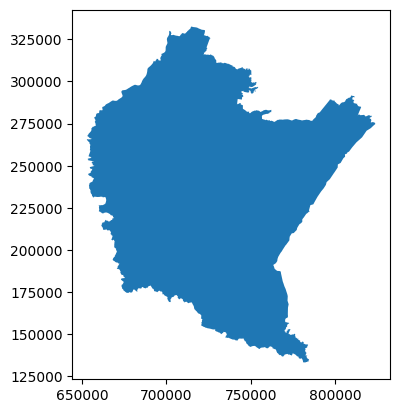

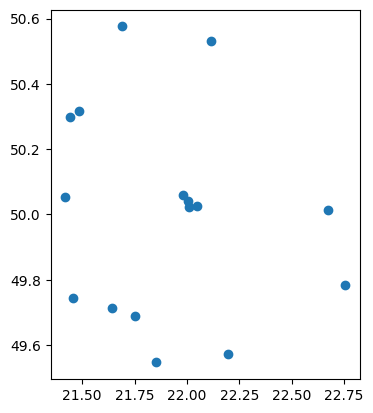

In [75]:
gdf_podkarpacie.plot()

### Variograms
Now let's investigate how few of our Variograms would look. Let's take the first 5 rows from our `pm10_df`

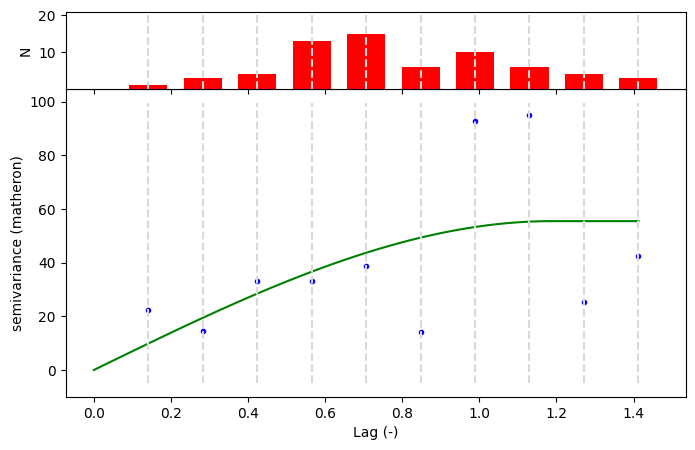

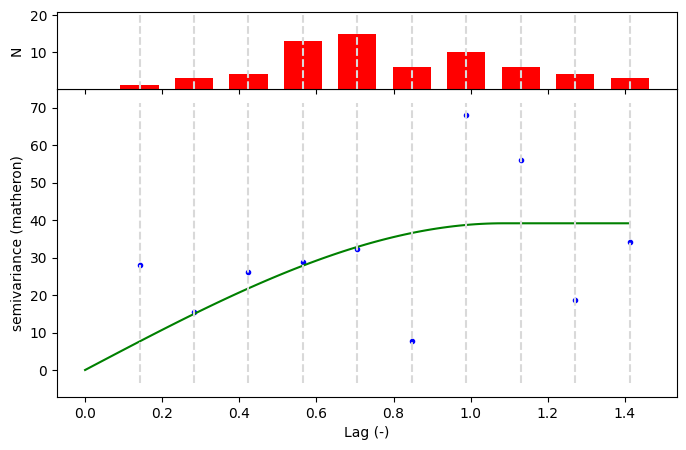

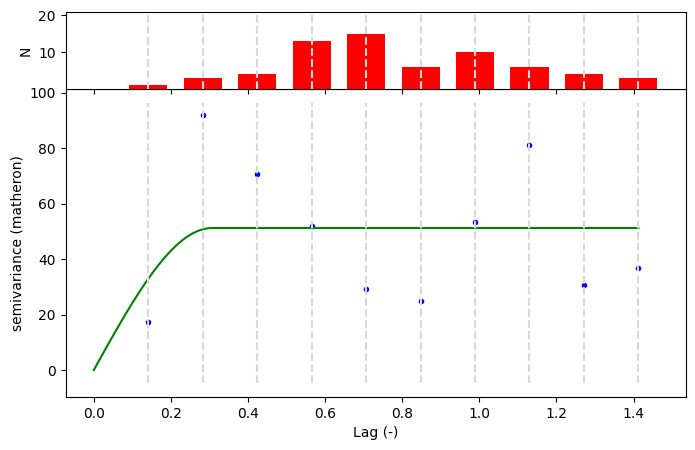

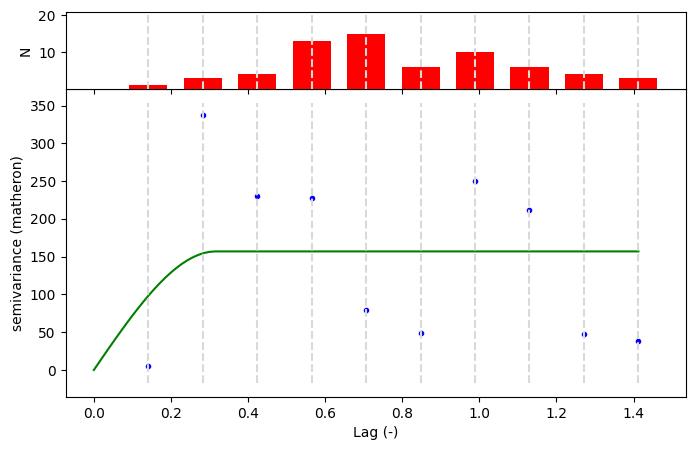

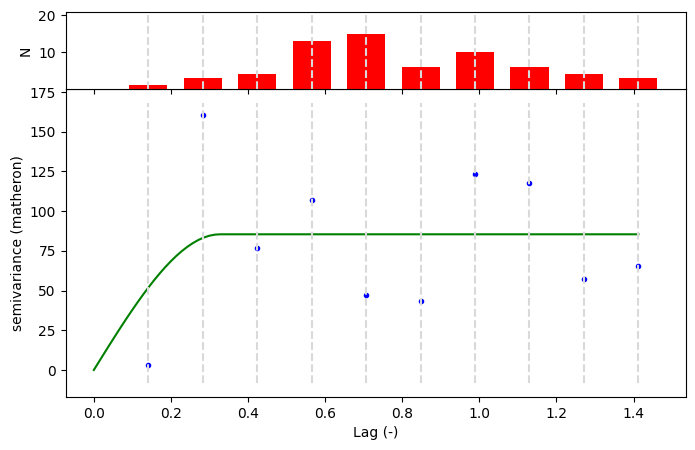

In [294]:
from skgstat import Variogram
import matplotlib.pyplot as plt

coordinates = gdf_podkarpacie_cities['geometry'].apply(lambda p: (p.x, p.y)).tolist()

for _, row in pm10_df.head().iterrows():
    row.name = "contamination"
    data = gdf_podkarpacie_cities.join(row, on='STATION_NA')

    values = list(map(float, data['contamination'].tolist()))

    V = Variogram(coordinates, values, model='spherical', maxlag=20, n_lags=10)

    fig = V.plot()
    plt.show()

### Interpolation function

All of our coordinates will stay the same for all rows, so we can define maximum and minimum values here.
We will also calculate the meshgrid for interpolations, as it will also stay the same

In [296]:
max_x = max(point.x for point in gdf_podkarpacie_cities['geometry']) + .1
max_y = max(point.y for point in gdf_podkarpacie_cities['geometry']) + .1
min_x = min(point.x for point in gdf_podkarpacie_cities['geometry']) - .1
min_y = min(point.y for point in gdf_podkarpacie_cities['geometry']) - .1

xx, yy = np.mgrid[min_x:max_x:100j, min_y:max_y:100j]

In [295]:
import skgstat as skg


def interpolate(V, ax, max_x, max_y, min_x, min_y):
    ok = skg.OrdinaryKriging(V, min_points=5, max_points=15, mode='exact')
    field = ok.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)
    return field

### Kriging plot

We chose one point of interest which is a [Biedronka grocery store in Strzyzow](https://maps.apple.com/place?q=Biedronka&auid=334584916135679909&address=W%20Witosa%2017,%2038-100%20Strzy%C5%BC%C3%B3w,%20Poland&ll=49.8700714,21.7989596).
We will calculate interpolations and statistics for this single point

In [ ]:
x_biedronka = 21.79
y_biedronka = 49.87

Let's plot one kriging and add cities with our Biedronka to it

/usr/local/lib/python3.10/dist-packages/matplotlib/contour.py:1454: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/usr/local/lib/python3.10/dist-packages/matplotlib/contour.py:1455: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


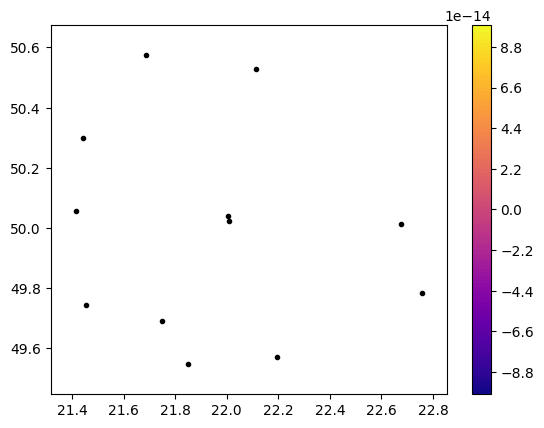

In [275]:
values = interpolate(V)

plt.contourf(xx, yy, values, 100, cmap='plasma')
plt.plot(gdf_podkarpacie_cities['geometry'].x, gdf_podkarpacie_cities['geometry'].y, 'k.')
plt.plot([x_biedronka], [y_biedronka], 'w.')
plt.text(x_biedronka, x_biedronka, 'biedronka', c='w')
plt.colorbar()

To find the interpolation values for our point we need to find the indexes in meshgrid

In [ ]:
tolerance = 1e-2
x_index = np.where(np.abs(xx - x_biedronka) < tolerance)[0][0]
y_index = np.where(np.abs(yy - y_biedronka) < tolerance)[0][0]

### Single point interpolation function
Now we can define a function that will return the value for our single point

In [313]:
def interpolate_single_point(V):
    ok = skg.OrdinaryKriging(V, min_points=1, max_points=15, mode='exact')
    field = ok.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)
    return field[x_index][y_index]

## Simulation calculations
Now for each row we calulate the interpolation values for our point

In [ ]:
kriging_values = []

for index, row in pm10_df.iterrows():
    row.name = "contamination"
    data = gdf_podkarpacie_cities.join(row, on='STATION_NA')
    coordinates = gdf_podkarpacie_cities['geometry'].apply(lambda p: (p.x, p.y)).tolist()

    values = list(map(float, data['contamination'].tolist()))

    try:
      V = Variogram(coordinates, values, model='spherical', maxlag=20, n_lags=10)
    except RuntimeError as e:
      print(f"Error for row {index}:\n{e}")
      continue

    value = interpolate_single_point(V)
    kriging_values.append(value)

## Statistics

Now with many calculated kriging values for our point we can calculate some statistics and probability of this point value being above the 3rd quartile

In [91]:
# Remove nans from krigin values
kriging_values = [value for value in kriging_values if not np.isnan(value)]

1329

Let's see how many samples we have

In [104]:
print(f"Number of samples: {len(kriging_values)}")

Number of samples: 1030


Next let's calculate some statistics for our point

In [96]:
kriging_values_mean = np.mean(kriging_values)

kriging_values_std = np.std(kriging_values)

kriging_values_upper = kriging_values_mean + kriging_values_std
kriging_values_lower = kriging_values_mean - kriging_values_std

kriging_values_q1 = np.quantile(kriging_values, 0.25)
kriging_values_q2 = np.quantile(kriging_values, 0.5)
kriging_values_q3 = np.quantile(kriging_values, 0.75)

In [106]:
print(f"Mean:               {kriging_values_mean:.4f}")
print(f"Standard deviation: {kriging_values_std:.4f}")
print(f"Upper bound:        {kriging_values_upper:.4f}")
print(f"Lower bound:        {kriging_values_lower:.4f}")
print(f"Q1:                 {kriging_values_q1:.4f}")
print(f"Q2:                 {kriging_values_q2:.4f}")
print(f"Q3:                 {kriging_values_q3:.4f}")
print(f"Min:                {min(kriging_values):.4f}")
print(f"Max:                {max(kriging_values):.4f}")

Mean:               13.5771
Standard deviation: 6.7315
Upper bound:        20.3086
Lower bound:        6.8456
Q1:                 8.6824
Q2:                 12.2124
Q3:                 16.8476
Min:                3.3000
Max:                38.9181


It will be easier to see on some plots

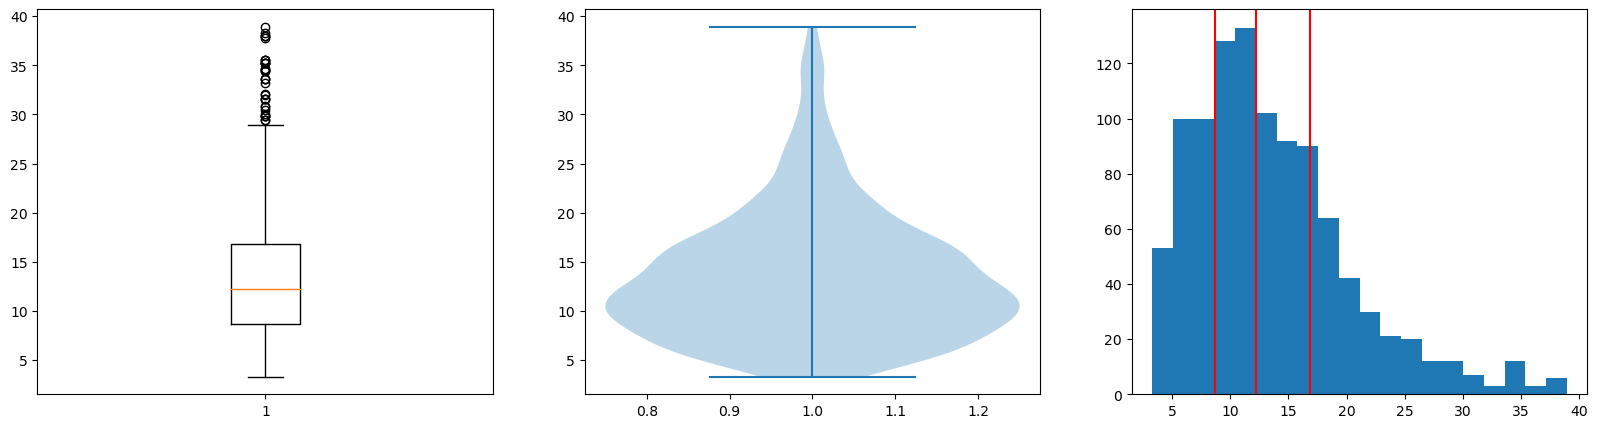

In [109]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].boxplot(kriging_values)

axes[1].violinplot(kriging_values)

axes[2].hist(kriging_values, bins=20)
axes[2].axvline(kriging_values_q1, color='red')
axes[2].axvline(kriging_values_q2, color='red')
axes[2].axvline(kriging_values_q3, color='red')

## Results
Finally let's calcualate the probability of the value being greater than the 3rd quartile

In [110]:
probability = len([value for value in kriging_values if value > kriging_values_q3]) / len(kriging_values)
print(f"Probability: {probability:.4f}")

Probability: 0.2495
